# Model-based Reinforcement Learning
## Introduction
### Planning and Learning
The model of a Markov Decision Process consists of a transition function $T$ and a reward function $R$.  

Planner: Outputs a policy from an MDP model. Dynamic programming, value iteration and policy iteration are planners.  
Learner: Outputs a policy from transitions $<s, a, r, s'>$.  

Modeler: Outputs a model from transitions (model learning).  
Simulator: Outputs transitions from a model.  

Reinforcement Learning-based Planner: Generates transitions based on a model and learns a policy from these transitions (model-free learner).  
Model-based Reinforcement Learner: Generates a model based on transitions and plans a policy from this model. 

### Three approaches to Reinforcement Learning
- Policy search algorithms: algorithms that work directly on finding the policy $\pi$.
- Value function-based approaches: methods that work directly on finding the value function $V$.
- Model-based reinforcement learners: methods that learn the transition and reward functions $T\&R$.

### Model-free VS Model-based
In which cases is it more efficient to use model-free approaches and in which cases is it more efficient to use model-based approaches?  
Advantages of model-free approaches over model-based ones:
- Not affected by modeling biases
- Only one source of approximation error since a policy is learnt instead of a policy and a model
- Easier to learn a good policy rather than learn a good model for many real world tasks (e.g. Robotic grasping behavior)
- The learn policy is not limited to be as good as the learn model  

Advantages of model-based approaches over model-free ones:
- Sample efficient: makes fuller use of limited experience with the real environment
- Allows us to use knowledge about the environment and not compute a policy from scratch with no indication  

Dyna-Q Algorithm:   
Samples real experience from the environment and uses it to do:  
- Model learning
- Direct Reinforcement Learning  
The model that is built from real experience is also used to do planning.

## Revenue Management game
For the moment we have only tried the Reinforcement Learning-based Planner approach: we work with an environment possessing a model to which we don't have access and generating transitions from which we try to learn a policy by using Reinforcement Learning algorithms, such as Q-Learning or Deep Q-Learning. 
 
In a world where competition is taken into consideration it might be too hard to learn the model and it may make more sense to use DQL approaches.
However it is true that with our single leg and monopoly environment it seems to be easier to learn the MDP model first and then use a planner to compute the policy rather than directly use complex learners such as Deep Q-Networks to find a policy from scratch.  

We thus decided to collect transitions from the environment and use a supervised learning approach to learn the transition function $T$ of the environment.   
$\forall s, \forall a, \forall s', T(s, a, s')$ gives us the probability to end up in $s'$ if we are in $s$ and take the action $a$.
Once we have access to the transition function it is easy to compute the reward function of our environment since we know that $R(s=(x,t), a, s'=(x',t')) = a(x'-x)$ if $x'>x$ and $0$ otherwise.  

In [1]:
import random 

def collect_transitions_DCP(env, nb_transitions):
    input, output = [], []
    for k in range(nb_transitions):
        state_idx = env.set_random_state()
        action_idx = random.randrange(env.action_space.n)
        next_state_idx, reward, done, _ = env.step(action_idx)
        input.append([state_idx, action_idx])
        output.append(next_state_idx)
    return input, output

def collect_transitions_flights(env, nb_flights):
    input, output = [], []
    for k in range(nb_flights):
        state_idx = env.reset()
        done = False
        while not done:
            action_idx = random.randrange(env.action_space.n)
            next_state_idx, reward, done, _ = env.step(action_idx)
            input.append([state_idx, action_idx])
            output.append(next_state_idx)
            state_idx = next_state_idx
    return input, output

def init_transitions(env, model):
    P = {s: {a: [] for a in range(env.nA)} for s in range(env.nS)}
    for t in range(env.T):
        for x in range(env.C):
            s = env.to_idx(t,x)
            for a in range(env.nA):
                P[s][a] = transitions(env, s, a, model)
    return P

def transitions(env, state, action, model):
    predictions = model.predict_proba(np.array([state, action]).reshape(1, -1))[0]

    list_transitions = []
    t, x = env.to_coordinate(state)
    done = False
    if t == env.T - 1 or x == env.C - 1:
        list_transitions.append((1, state, 0, True))
    else:
        for k in range(len(predictions)):
            reward = 0
            proba_next_state = predictions[k]
            next_state = k + env.C
            if next_state > state + env.C and next_state <= state + 2*env.C:
                reward = env.A[action]*abs(state + env.C - next_state)
            new_t, new_x = env.to_coordinate(next_state)
            if new_t == env.T - 1 or new_x == env.C - 1:
                done = True

            list_transitions.append((proba_next_state, next_state, reward, done))

    return list_transitions

We use a discrete environment:

In [2]:
import gym

data_collection_points = 10
micro_times = 5
capacity = 10
actions = tuple(k for k in range(50, 231, 50))
alpha = 0.8
lamb = 0.7
env = gym.make('gym_RMDCPDiscrete:RMDCPDiscrete-v0', data_collection_points=data_collection_points,
                capacity=capacity,
                micro_times=micro_times, actions=actions, alpha=alpha, lamb=lamb)

Here are the optimal values and policy that we get when we use the true model of the environment in the value iteration algorithm:

Converged at 9
Average reward over 10000 episodes : 1039.4


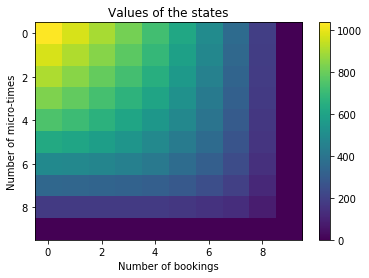

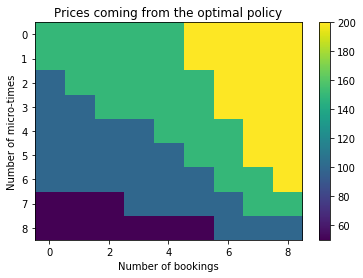

In [8]:
%run ../value_iteration.py
%run ../visualization_and_metrics 

values_DP = value_iteration_discrete(env, 100_000, 1e-20)
policy_DP = extract_policy_RM_discrete(env, values_DP, 0.99)
visualisation_value_RM(values_DP, env.T, env.C)
visualize_policy_RM(policy_DP, env.T, env.C)
print("Average reward over 10000 episodes : " + str(average_n_episodes(env, policy_DP, 10000)))

Here are the results that we get when we use the model computed through supervised learning in the value iteration algorithm.  
In this case the transitions are collected in the following way: 
- A state $s$ is picked up uniformly from the environment and an action $a$ is picked up uniformly from the action space. $s$ and $a$ represent the input of our classifier.
- The environment then provides us with a next state $s'$, which represents the output of our classifier.

c:\users\oriou\envs\rl_for_rm_oksana\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Converged at 14
Average reward over 10000 episodes : 985.55


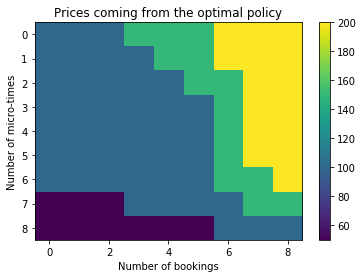

In [9]:
from sklearn.neural_network import MLPClassifier
%run ../value_iteration.py
%run ../visualization_and_metrics 

X_train, y_train = collect_transitions_DCP(env, 10_000)

clf = MLPClassifier(hidden_layer_sizes=(50,50,))
clf.fit(X_train, y_train)

transitions_dic = init_transitions(env, clf)
values_RL = value_iteration_discrete(env, 100_000, 1e-20, transitions_dic)
policy_RL = extract_policy_RM_discrete(env, values_RL, 0.99, transitions_dic)
visualize_policy_RM(policy_RL, env.T, env.C)
print("Average reward over 10000 episodes : " + str(average_n_episodes(env, policy_RL, 10000)))


In the following case the transitions are collected as follows:
- We start with the initial state $s=(0,0)$
- While the game is not ended: 
    - an action $a$ is picked up uniformly from the action space and we get $s'$ from the environment
    - $s$ and $a$ are placed in the input list
    - $s'$ is placed in the output list
    - $s = s'$


Converged at 19
Average reward over 10000 episodes : 595.665


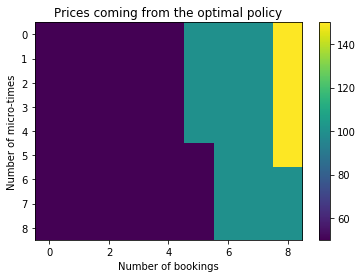

In [10]:
from sklearn.neural_network import MLPClassifier
%run ../value_iteration.py
%run ../visualization_and_metrics 

X_train, y_train = collect_transitions_flights(env, 10_000)

clf = MLPClassifier(hidden_layer_sizes=(50,50,))
clf.fit(X_train, y_train)

transitions_dic = init_transitions(env, clf)
values_RL = value_iteration_discrete(env, 100_000, 1e-20, transitions_dic)
policy_RL = extract_policy_RM_discrete(env, values_RL, 0.99, transitions_dic)
visualize_policy_RM(policy_RL, env.T, env.C)
print("Average reward over 10000 episodes : " + str(average_n_episodes(env, policy_RL, 10000)))

As we can see the average revenue that we can get using model-based RL approaches is higher when the transitions collected from the environment come from DCPs and not flights.